# Package

In [2]:
#Torch related package
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchviz

In [3]:
#cuda related package
import torch.cuda
import torch.backends.cudnn as cudnn
print(torch.backends.cudnn.version())

6021


In [323]:
# Other package
import time
import random
import pandas as pd
from ggplot import *
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

In [7]:
#%run Annexe.ipynb #Good trick to launch another notebook

# Commentaire pour la suite (TODO)

Le batch normalisation, il y en existe plusieurs, regarder exactement lequel on veut.

On peut enlever le biais dans les convolutions avant la normalisation

Le diminution de la taille des images, pas clair cette division par deux....

Change la fonction de cout

Il faut enlever les biais quand il y a une batch normalisation apres

# Entrainement 

In [80]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [87]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [88]:
print(trainset.)

# CityscapesLoader

In [86]:
class color():
    convolution        = "darkgoldenrod1"
    subSampling        = "darkgoldenrod" 
    fullConvolution    = "firebrick1"
    upSampling         = "firebrick"
    batchNormalization = "deepskyblue3"
    relu               = "darkolivegreen3"
    add                = "bisque3"
    dropout            = "darkviolet"

In [83]:
classes = ['road', 'sidewalk','building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
           'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus','train', 'motorcycle', 'bicycle']
number_classes = len(classes)

#  GridNet

In [84]:
class firstConv(nn.Module):
    
    """
    (1) = nInputs : number of features map for the input
    (2) = nOutputs : number of features map for the output
    This is the first convolution used to enter into the grid.
    """
    def __init__(self,nInputs,nOutputs):
        super(firstConv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch1 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
                
        self.ReLU2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.ReLU1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.ReLU2(x)
        return x

    
net = firstConv(nInputs = 3,nOutputs = 3)
print(net)

firstConv(
  (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU1): ReLU()
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU2): ReLU()
)


In [12]:
class convSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    (3) = dropFactor : Total Dropout on the entire Sequence, there is a probability p = dropFactor that
        the residual is deleted.
    This class reprensent a residual bloc that doesn't change number nor the size of the features maps
    """
    def __init__(self,nInputs,nOutputs,dropFactor):
        super(convSequence, self).__init__()
        self.dropFactor = dropFactor
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU2 = nn.ReLU()
        
        
    def forward(self, x_init):
        x = self.batch1(x_init)
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        # Small trick that transform boolean into integer
        x = ((random.random() > self.dropFactor) * 1) * x
        x = x_init + x
        return x

    
net = convSequence(nInputs = 3,nOutputs = 3,dropFactor = 0.1)
print(net)

convSequence(
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1): ReLU()
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
)


In [13]:
class subSamplingSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    This class represente a bloc that reduce the resolution of each feature map(factor2)
    """
    def __init__(self, nInputs, nOutputs):
        super(subSamplingSequence, self).__init__()
        
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(2,2), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)

        self.ReLU2 = nn.ReLU()

    def forward(self, x):
        x = self.batch1(x)
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        return x

    
network = subSamplingSequence(nInputs = 3,nOutputs = 6)
print(network)
a = torch.randn(2, 3, 7, 7)
inputs = Variable(a)
out = network(inputs)
print(out.size())

subSamplingSequence(
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d (3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (ReLU1): ReLU()
  (batch2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
)
torch.Size([2, 6, 4, 4])


In [14]:
class upSamplingSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    This class represente a bloc that increase the resolution of each feature map(factor2)
    """
    def __init__(self, nInputs, nOutputs):
        super(upSamplingSequence, self).__init__()
        
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.convTranspose1 = nn.ConvTranspose2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(2,2), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)

        self.ReLU2 = nn.ReLU()

        
    def forward(self, x):
        x = self.batch1(x)
        x = self.convTranspose1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        return x


network = upSamplingSequence(nInputs = 6,nOutputs = 3)
print(network)
a = torch.randn(2, 6, 16, 16)
inputs = Variable(a)
out = network(inputs)
print(out.size())

#

upSamplingSequence(
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (convTranspose1): ConvTranspose2d (6, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (ReLU1): ReLU()
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
)
torch.Size([2, 3, 31, 31])


In [15]:
class lastConv(nn.Module):
    
    """
    (1) = nInputs : number of features map for the input
    (2) = nOutputs : number of features map for the output
    This class represente the last Convolution of the network before the prediction
    """
    def __init__(self,nInputs,nOutputs):
        super(lastConv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch1 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
                
        self.ReLU2 = nn.ReLU()

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.ReLU1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.ReLU2(x)
        return x

    
net = lastConv(nInputs = 3,nOutputs = 3)
print(net)


lastConv(
  (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU1): ReLU()
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU2): ReLU()
)


In [16]:
class gridNet(nn.Module):
    
    """
    (1) = nInput : number of features maps for the input
    (2) = nOutput : number of features maps for the output
    (3) = nColumns : number of columns of the gridNet, this number should be divisible by two.
    It count the number of bloc +1
    (4) = nFeatMaps : number of feature at each row of the gridNet
    (5) = dropFactor : factor witch control the dropout of an entire bloc 
    """
    def __init__(self,nInputs, nOutputs, nColumns, nFeatMaps, dropFactor):
        super(gridNet, self).__init__()
        
        #Define some parameters as an attribut of the class
        len_nfeatureMaps = len(nFeatMaps)
        self.nColumns = nColumns
        self.nFeatMaps = nFeatMaps
        self.len_nfeatureMaps = len_nfeatureMaps
        
        # A normalisation before any computation
        self.batchNormInitial = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        # The first convolution before entering into the grid.
        self.firstConv = firstConv(nInputs = nInputs, nOutputs = nInputs)
        
        
        # We create the Grid. We will creat conv and sub/up sequences with different name.
        # The name is : "sequenceName" + starting position of the sequence(i,j) + "to" + ending position (k,l)
        for i in range(len(nFeatMaps)):
            for j in range(nColumns):
                #We don t creat a residual bloc on the last column
                if(j < (nColumns - 1)):
                    setattr(self, "convSequence" + str(i) + "_" + str(j) + "to" + str(i) + "_" + str(j + 1),
                            convSequence(nFeatMaps[i], nFeatMaps[i],dropFactor))
                
                #We creat subSampling only on half of the grid and not in the last row
                if(j < (nColumns // 2) and i < (len(nFeatMaps)-1)):
                    setattr(self, "subSamplingSequence" + str(i) + "_" + str(j) + "to" + str(i + 1) + "_" + str(j),
                            subSamplingSequence(nFeatMaps[i], nFeatMaps[i+1]))
                
                #Welook a the other half but not the first row
                if(j >= (nColumns // 2) and i > 0):
                    setattr(self, "upSamplingSequence" + str(i) + "_" + str(j) + "to" + str(i - 1) + "_" + str(j),
                            upSamplingSequence(nFeatMaps[i], nFeatMaps[i-1]))

        # The last convolution before the result.
        self.lastConv = lastConv(nInputs = nFeatMaps[0], nOutputs = nOutputs)    
    
        self.batchNormFinal = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0,affine=True)
        
        self.logsoftmax1 = nn.LogSoftmax()
        
        
    
    """This function return the fusion of the actual value on (i,j) and the new data which come from the sampling
    (1) = X_i_j : The value on the grid a the position (i,j)
    (2) = SamplingSequence : The sampling that should be added to the point (i,j)
    """
    def addTransform(self,X_i_j,SamplingSequence):
        return(X_i_j + SamplingSequence)
    
    
    
    def forward(self, x):

        # A normalisation before any computation
        x = self.batchNormInitial(x)
        # The first convolution before entering into the grid.
        x = self.firstConv(x)
        
        # X is the matrix that represente the values of the features maps at the point (i,j) in the grid.
        X = [[0 for i in range(self.nColumns)] for j in range(self.len_nfeatureMaps)]
        #The input of the grid is on (0,0)
        X[0][0] = x
        
        # Looking on half of the grid, with sumsampling and convolution sequence
        for j in range(self.nColumns//2):
            for i in range(self.len_nfeatureMaps):
                #For the first column, there is only subsampling
                if(j > 0):
                    #This syntaxe call self.conSequencei_(j-1)toi_j(X[i][j-1])
                    X[i][j] = getattr(self,"convSequence"
                                      + str(i) + "_" + str(j-1) + "to" + str(i) + "_" + str(j))(X[i][j-1])
                
                # For the first row, there is only ConvSequence (residual bloc)
                if(i > 0):
                    X[i][j] = self.addTransform(X[i][j] , getattr(self,"subSamplingSequence"
                                                + str(i-1) + "_" + str(j) + "to" + str(i) + "_" + str(j))(X[i-1][j]))

        # Looking on the other half of the grid
        for j in range(self.nColumns//2,self.nColumns):
            for i in range(self.len_nfeatureMaps-1,-1,-1):
                X[i][j] = getattr(self,"convSequence" +
                                      str(i) + "_" + str(j-1) + "to" + str(i) + "_" + str(j))(X[i][j-1])

                
                # There is no upSampling on the last row
                if(i < (self.len_nfeatureMaps - 1)):
                    X[i][j] = self.addTransform(X[i][j], getattr(self,"upSamplingSequence"
                                                + str(i+1) + "_" + str(j) + "to" + str(i) + "_" + str(j))(X[i+1][j]))

        x_final = self.lastConv(X[0][self.nColumns - 1])

        if(False):
            print("Size of different X_i_j")
            for i1,i2 in enumerate(X):
                for j1,j2 in enumerate(i2):
                    print("Dim(X(" + str(i1) + ")(" + str(j1) + ")) : ",j2.size())
             

        return x_final


network = gridNet(nInputs = 3,nOutputs = number_classes, nColumns = 4, nFeatMaps = [3,6,12,24], dropFactor = 0.1)
print(network)


gridNet(
  (batchNormInitial): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (firstConv): firstConv(
    (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (ReLU1): ReLU()
    (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (ReLU2): ReLU()
  )
  (convSequence0_0to0_1): convSequence(
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU1): ReLU()
    (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU2): ReLU()
  )
  (subSamplingSequence0_0to1_0): subSamplingSequence(
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv1): Conv2d (3, 6, kernel_size=(3, 3), stride=(2, 2),

# Train

In [72]:
class Parameters():
    def __init__(self,nColumns, nFeatMaps, dropFactor,learning_rate,number_classes, beta1, beta2,epsilon,
                weight_decay,width_image, height_image,nFeatureMaps_init,batch_size,epoch_number):
        super(Parameters, self).__init__()
        # Image
        self.number_classes = number_classes
        self.width_image = width_image
        self.height_image = height_image
        # Number of feature map at the begining, if RGB image it would be 3
        self.nFeatureMaps_init = nFeatureMaps_init
        
        # GridNet
        self.nColumns = nColumns
        self.nFeatMaps = nFeatMaps
        
        # Learning
        self.dropFactor = dropFactor
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epoch_number = epoch_number


In [281]:
"""Define the loss function between the y_train_estimated and y_train"""
def criterion(y_estimated, y):
    nllcrit = nn.NLLLoss2d()
    return nllcrit(F.log_softmax(y_estimated, dim = 1), y)

In [241]:
"""train return
    (0) = parameters : list of parameters of the network
    (1) = x_train : inputs of the training set
    (2) = y_train : outputs of the training set
    (3) = x_validation : inputs of the validation set
    (4) = y_validation : outputs of the validation set
"""
def train(parameters,network,x_train,y_train,x_validation,y_validation):
     
    # We will use this one a lot, so we compute it now
    x_train_len = x_train.size()[0]
        
    # create your optimizer
    optimizer = optim.Adam(params = network.parameters(), lr=parameters.learning_rate,
                           betas = (parameters.beta1, parameters.beta2),
                           eps = parameters.epsilon, weight_decay = parameters.weight_decay)

    #list
    conf_mat_train = np.zeros((parameters.epoch_number,parameters.number_classes,parameters.number_classes))
    IoU_classes_train = np.zeros((parameters.epoch_number,parameters.number_classes))
    IoU_total_train = np.zeros((parameters.epoch_number))
    loss_train = np.zeros((parameters.epoch_number))
    
    for epoch in range(parameters.epoch_number):
        
        # We apply a random permutation at each epoch
        random_perm = torch.randperm(x_train_len)
        
        #trainloader=torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
        #testloader=torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)
        
        for batch in range(0,x_train.size()[0], batch_size):
            # zero the gradient buffers
            optimizer.zero_grad()
            
            indices = random_perm[batch:min(batch+batch_size,x_train_len-1)]
            x_batch, y_batch = x_train[indices], y_train[indices]
            
            # Compute the forward function
            y_batch_estimated = network(x_batch)

            #Get the error
            loss = criterion(y_batch_estimated, y_batch)            
            
            #Compute the backward function
            loss.backward()

            # Does the update according to the optimizer define above
            optimizer.step()

        # Save the error
        save_error(x_train,y_train,x_validation,y_validation,network,True)
        
        
    
        conf_mat_train[epoch], b, IoU_total_train[epoch] = IoU(y_train_estimated,y_train)

        IoU_classes_train = pd.DataFrame(columns=["Value","Target","Prediction","Epoch"])
        epoch_axis = pd.DataFrame([epoch]*parameters.number_classes,columns=["Epoch"])
        b = pd.concat[(b,epoch_axis),axis = 1]
        IoU_classes_train = pd.concat[(IoU_classes_train,b)]
        
        
    return(loss_train,conf_mat_train,pd.DataFrame(IoU_classes_train,columns=["t" + str(i) for i in range(19)]),IoU_total_train)

In [272]:
pd.DataFrame([10,4] for i in range(parameters.number_classes),columns=["Epoch"])

SyntaxError: Generator expression must be parenthesized if not sole argument (<ipython-input-272-1af47f4cfe97>, line 1)

In [265]:
pd.DataFrame(columns=["ok","bla"])

,ok,bla


In [304]:
"a".encode()

b'a'

In [309]:
# Define Data
RESULTS = ['apple','cherry','orange','pineapple','strawberry']

# Open File
resultFyle = open("output.csv",'w')

# Write data to file
for r in RESULTS:
    resultFyle.write(r + ",")
resultFyle.close()

In [322]:
import csv    

with open('v.csv', 'w') as csvfile:
    cwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    cwriter.writerow(RESULTS)

In [319]:
import csv
RESULTS = ['apple','cherry']
#RESULTS = ['apple','cherry','orange','pineapple','strawberry']

with open("output.csv",'wb') as resultFile:
    for r in RESULTS:
        resultFyle.write(r + ",")

ValueError: I/O operation on closed file.

In [289]:
a = np.asarray(["Value","True","Prediction","Type", "Group","Epoch"])
np.savetxt("foo.csv", a, delimiter=",")

TypeError: Mismatch between array dtype ('<U10') and format specifier ('%.18e')

# Save Data

In [336]:
def init_scv(name_network,train_number):
    
    if(exists("CSV/CSV_confMat_" + "train" + "_" + name_network + str(train_number) + ".csv")):
        print("TODO ici il faudra faire arreter le programme ! On ecrase les fichiers !")
        #TODO ici il faudra faire arreter le programme !
    header_confMat = ["Value","Target","Prediction","Epoch"]
    header_loss = ["Value"]
    
    for t in ["train","validation"]:
        with open("CSV/CSV_confMat_" + t + "_" + name_network + str(train_number) + ".csv", 'w') as csvfile:
            cwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
            cwriter.writerow(header_confMat)

        with open("CSV/CSV_loss_" + t + "_" + name_network + str(train_number) + ".csv", 'w') as csvfile:
            cwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
            cwriter.writerow(header_loss)

In [337]:
init_scv(0)

TODO ici il faudra faire arreter le programme ! On ecrase les fichiers !


In [346]:
with open('foo.csv', 'a') as csvfile:
    writer = csv.writer(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    writer.writerows([[1,2,3],[4,5,6]])

In [340]:
np.savetxt("foo.csv", [1,2,3], delimiter=",")


In [ ]:
def save_error(x_train,y_train,x_validation,y_validation,network,epoch):
    
    y_train_estimated = network(x_train)
    y_validation_estimated = network(y_validation)
    conf_mat_train = IoU(y_train_estimated,y_train)
    conf_mat_validation = IoU(y_validation_estimated,y_validation)
    
    for t in ["train","validation"]:
        with open("CSV/CSV_confMat_" + t + "_" + name_network + str(train_number) + ".csv", 'a') as csvfile:
            writer = csv.writer(csvfile, quoting=csv.QUOTE_NONNUMERIC)
            writer.writerows()
            
    loss_train = criterion(y_estimated = y_train_estimated,y = y_train)
    loss_validation = criterion(y_estimated = y_validation_estimated,y = y_validation)
    
    
    for t in ["train","validation"]:
        with open("CSV/CSV_confMat_" + t + "_" + name_network + str(train_number) + ".csv", 'a') as csvfile:
            writer = csv.writer(csvfile, quoting=csv.QUOTE_NONNUMERIC)
            writer.writerows()
    
    loss_train[epoch] = loss


# Test

In [256]:
"""
    Test function : IoU
    return a matrix of confusion
"""
def IoU(y_train_estimated, y_train):
    
    #We keep only the higest value, which is the prediction
    pred = torch.max(y_train_estimated, dim=1)[1]

    confusion_matrix = [[0] * parameters.number_classes for i in range(parameters.number_classes)]
    
    #For each classes : [0] = TP [1] = FP [2] = FN
    IoU_each_classes = np.zeros(shape = (3,parameters.number_classes))

    pred = pred.view(-1)
    target = y_train.view(-1)

    # Double loop over the number of classes at each iteration we add the intersection
    for cls1 in range(parameters.number_classes):
        pred_inds = pred == cls1
        for cls2 in range(parameters.number_classes):
            target_inds = target == cls2
            intersection = (pred_inds*target_inds).long().sum().data.cpu()[0]
            confusion_matrix[cls1][cls2] = intersection

            # TP here for each classes
            if(cls1 == cls2):
                IoU_each_classes[0,cls1] = intersection
            # FN and FP here for each classes
            else:
                IoU_each_classes[1,cls1] = IoU_each_classes[1,cls1] + intersection
                IoU_each_classes[2,cls2] = IoU_each_classes[2,cls1] + intersection
    
    # compute the IoU value
    IoU_each_classes_total = IoU_each_classes[0,:]/np.sum(IoU_each_classes)

    return(confusion_matrix,IoU_each_classes_total, np.mean((np.float32(IoU_each_classes_total))))
    

In [275]:
torch.manual_seed(789)
random.seed(465)

batch_size = 3
image_size = 33
a = torch.randn(batch_size, 3, image_size, image_size)

b = (torch.rand(batch_size,image_size,image_size)*1000)%19

x_train = Variable(a)
y_train = Variable(b).long()

x_validation = Variable(b)
y_validation = Variable(b)


parameters = Parameters(nColumns = 4, learning_rate=0.01, nFeatMaps = [3,6],dropFactor = 0.1,
                        number_classes = 19, weight_decay = 5*10**(-6), beta1 = 0.9,
                        beta2 = 0.999, epsilon = 1*10**(-8), width_image = image_size, height_image = image_size,
                        nFeatureMaps_init = len(x_train[0,:,0,0]), batch_size = batch_size,epoch_number = 100)




# Define the GridNet
network = gridNet(nInputs = parameters.nFeatureMaps_init,nOutputs = parameters.number_classes, nColumns = parameters.nColumns,
                      nFeatMaps = parameters.nFeatMaps, dropFactor = parameters.dropFactor)

#network = network.cuda()
#x_train = x_train.cuda()
#y_train = y_train.cuda()

train(network = network, parameters = parameters, x_train=x_train, y_train=y_train, x_validation= x_validation,y_validation = y_validation)
plot_training(loss_train,conf_mat_train,IoU_classes_train,IoU_total_train)

TypeError: train() got an unexpected keyword argument 'x_validation'

# Resize

In [ ]:
def resize(x_train,y_train):
    

In [ ]:
def 

In [ ]:
def 

# Plot

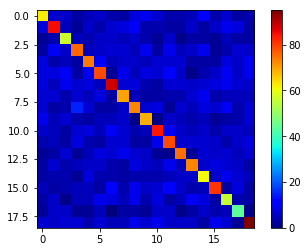

In [244]:
def plot_training(loss_train,conf_mat_train,IoU_classes_train,IoU_total_train):
    fig = plt.figure(1)
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_mat_train[-1]), cmap=plt.cm.jet, 
                    interpolation='nearest')
    cb = fig.colorbar(res)
    plt.show()
    
    ggplot(aes(),data = IoU_classes_train)+ geom_point(x="0",y="1")
    

    



plot_training(loss_train,conf_mat_train,IoU_classes_train,IoU_total_train)

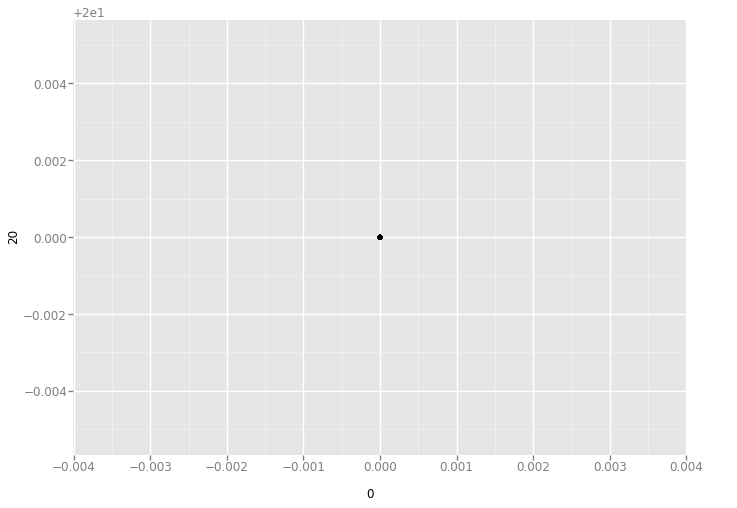

<ggplot: (-9223363309091037822)>

In [245]:
ggplot(aes(x="",y="20"),data = IoU_classes_train)+ geom_point()

In [237]:
meat

,date,beef,veal,pork,lamb_and_mutton
0,1944-01-01,751.0,85.0,1280.0,89.0
1,1944-02-01,713.0,77.0,1169.0,72.0
2,1944-03-01,741.0,90.0,1128.0,75.0
3,1944-04-01,650.0,89.0,978.0,66.0
4,1944-05-01,681.0,106.0,1029.0,78.0
5,1944-06-01,658.0,125.0,962.0,79.0
6,1944-07-01,662.0,142.0,796.0,82.0
7,1944-08-01,787.0,175.0,748.0,87.0
8,1944-09-01,774.0,182.0,678.0,91.0
9,1944-10-01,834.0,215.0,777.0,100.0


In [246]:
IoU_classes_train

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18
0,0.000304,0.002582,0.000000,0.002279,0.003342,0.001519,0.004405,0.002431,0.000456,0.000608,0.001823,0.002886,0.003646,0.003190,0.001519,0.002582,0.000000,0.000000,0.004405
1,0.000302,0.004377,0.000302,0.003018,0.004377,0.002113,0.004980,0.002415,0.001358,0.001056,0.002867,0.002867,0.003622,0.004377,0.001509,0.003320,0.000000,0.000000,0.005433
2,0.000468,0.003434,0.001561,0.003434,0.004527,0.003122,0.004059,0.003122,0.001405,0.001405,0.003278,0.003434,0.003590,0.003434,0.001249,0.002966,0.000312,0.000156,0.005151
3,0.000914,0.006246,0.001523,0.005789,0.003809,0.002895,0.005180,0.003504,0.001980,0.001980,0.004418,0.003809,0.004723,0.003961,0.002438,0.003199,0.000152,0.000000,0.007922
4,0.001252,0.006572,0.001878,0.005789,0.004694,0.002973,0.005789,0.004225,0.002660,0.002504,0.004538,0.004068,0.005164,0.004068,0.002504,0.003912,0.000156,0.000000,0.007667
5,0.001116,0.007018,0.002552,0.005901,0.005582,0.003509,0.006699,0.004466,0.003349,0.003030,0.005901,0.004147,0.004944,0.004147,0.002552,0.004625,0.000319,0.000000,0.007815
6,0.000782,0.007661,0.002345,0.005316,0.005629,0.003127,0.006567,0.004690,0.002502,0.003283,0.005941,0.004221,0.004690,0.003283,0.002189,0.004847,0.000156,0.000156,0.007348
7,0.000805,0.009012,0.003058,0.007724,0.006759,0.003701,0.008529,0.004989,0.004345,0.003540,0.006759,0.004828,0.004989,0.004667,0.002414,0.004989,0.000644,0.000161,0.008368
8,0.001170,0.007854,0.002841,0.006684,0.007019,0.004846,0.008021,0.004846,0.002507,0.003509,0.006016,0.005180,0.004846,0.003844,0.001671,0.003844,0.000501,0.000000,0.007854
9,0.000962,0.009140,0.003047,0.008339,0.006895,0.004650,0.010584,0.006414,0.004490,0.003688,0.007858,0.006735,0.005613,0.004330,0.003368,0.005292,0.000802,0.000000,0.008659


In [225]:
IoU_classes_train.columns.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [254]:
from ggplot import meat
meat_lng = pd.melt(meat, id_vars=['date'])
meat_lng

,date,variable,value
0,1944-01-01,beef,751.0
1,1944-02-01,beef,713.0
2,1944-03-01,beef,741.0
3,1944-04-01,beef,650.0
4,1944-05-01,beef,681.0
5,1944-06-01,beef,658.0
6,1944-07-01,beef,662.0
7,1944-08-01,beef,787.0
8,1944-09-01,beef,774.0
9,1944-10-01,beef,834.0


In [255]:
ggplot(IoU_classes_train, aes()) + geom_point()

Exception: y needed for <ggplot.geoms.geom_point.geom_point object at 0x7f017153ee10>

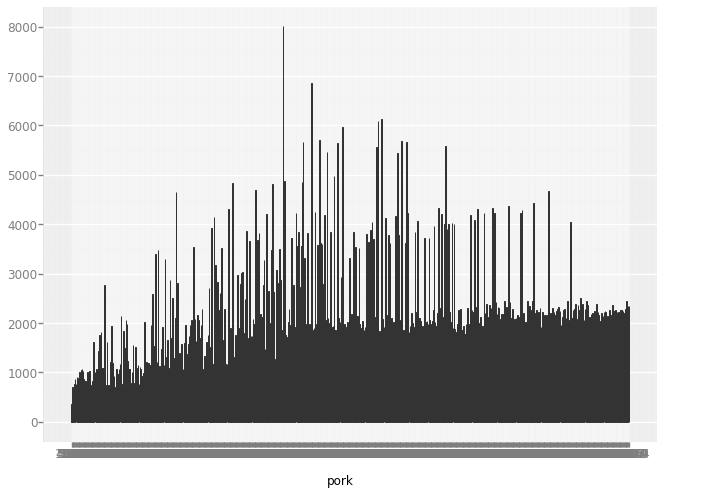

<ggplot: (-9223363309090736829)>

In [239]:
meat = meat.dropna(thresh=800, axis=1) # drop columns that have fewer than 800 observations
ts = meat.set_index(['date'])

ggplot(meat, aes('pork', weight='beef')) + geom_bar() + scale_y_continuous(labels='comma')

In [214]:
IoU_classes_train.name()

AttributeError: 'DataFrame' object has no attribute 'name'

# Graphical representation of the grid

In [46]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.autograd import Variable, Function
from collections import defaultdict
import graphviz

"""
This is a rather distorted implementation of graph visualization in PyTorch.
This implementation is distorted because PyTorch's autograd is undergoing refactoring right now.
- neither func.next_functions nor func.previous_functions can be relied upon
- BatchNorm's C backend does not follow the python Function interface
- I'm not even sure whether to use var.creator or var.grad_fn (apparently the source tree and wheel builds use different
  interface now)
As a result, we are forced to manually trace the graph, using 2 redundant mechanisms:
- Function.__call__: this allows us to trace all Function creations. Function corresponds to Op in TF
- Module.forward_hook: this is needed because the above method doesn't work for BatchNorm, as the current C backend does
  not follow the Python Function interface. 
To do graph visualization, follow these steps:
1. register hooks on model: register_vis_hooks(model)
2. pass data through model: output = model(input)
3. remove hooks           : remove_vis_hooks()
4. perform visualization  : save_visualization(name, format='svg') # name is a string without extension
"""


old_function__call__ = Function.__call__

def register_creator(inputs, creator, output):
    """
    In the forward pass, our Function.__call__ and BatchNorm.forward_hook both call this method to register the creators
    inputs: list of input variables
    creator: one of
        - Function
        - BatchNorm module
    output: a single output variable
    """
    cid = id(creator)
    oid = id(output)
    if oid in vars: 
        return
    # connect creator to input
    for input in inputs:
        iid = id(input)
        func_trace[cid][iid] = input
        # register input
        vars[iid] = input
    # connect output to creator
    assert type(output) not in [tuple, list, dict]
    var_trace[oid][cid] = creator
    # register creator and output and all inputs
    vars[oid] = output
    funcs[cid] = creator

hooks = []

def register_vis_hooks(model):
    global var_trace, func_trace, vars, funcs
    remove_vis_hooks()
    var_trace  = defaultdict(lambda: {})     # map oid to {cid:creator}
    func_trace = defaultdict(lambda: {})     # map cid to {iid:input}
    vars  = {}                               # map vid to Variable/Parameter
    funcs = {}                               # map cid to Function/BatchNorm module
    hooks = []                               # contains the forward hooks, needed for hook removal

    def hook_func(module, inputs, output):
        assert 'BatchNorm' in mod.__class__.__name__        # batchnorms don't have shared superclass
        inputs = list(inputs)
        for p in [module.weight, module.bias]:
            if p is not None:
                inputs.append(p)
        register_creator(inputs, module, output)

    for mod in model.modules():
        if 'BatchNorm' in mod.__class__.__name__:           # batchnorms don't have shared superclass
            hook = mod.register_forward_hook(hook_func)
            hooks.append(hook)

    def new_function__call__(self, *args, **kwargs):
        inputs =  [a for a in args            if isinstance(a, Variable)]
        inputs += [a for a in kwargs.values() if isinstance(a, Variable)]
        output = old_function__call__(self, *args, **kwargs)
        register_creator(inputs, self, output)
        return output

    Function.__call__ = new_function__call__


def remove_vis_hooks():
    for hook in hooks:
        hook.remove()

    Function.__call__ = old_function__call__


def save_visualization(name, format='svg'):
    g = graphviz.Digraph(format=format)
    def sizestr(var):
        size = [int(i) for i in list(var.size())]
        return str(size)
    # add variable nodes
    for vid, var in vars.iteritems():
        if isinstance(var, nn.Parameter):
            g.node(str(vid), label=sizestr(var), shape='ellipse', style='filled', fillcolor='red')
        elif isinstance(var, Variable):
            g.node(str(vid), label=sizestr(var), shape='ellipse', style='filled', fillcolor='lightblue')
        else:
            assert False, var.__class__
    # add creator nodes
    for cid in func_trace:
        creator = funcs[cid]
        g.node(str(cid), label=str(creator.__class__.__name__), shape='rectangle', style='filled', fillcolor='orange')
    # add edges between creator and inputs
    for cid in func_trace:
        for iid in func_trace[cid]:
            g.edge(str(iid), str(cid))
    # add edges between outputs and creators
    for oid in var_trace:
        for cid in var_trace[oid]:
            g.edge(str(cid), str(oid))
    g.render(name)
class subSamplingSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    This class represente a bloc that reduce the resolution of each feature map(factor2)
    """
    def __init__(self, nInputs, nOutputs):
        super(subSamplingSequence, self).__init__()
        self.Seque
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(2,2), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)

        self.ReLU2 = nn.ReLU()

    def forward(self, x):
        x = self.batch1(x)
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        return x

    
network = subSamplingSequence(nInputs = 3,nOutputs = 6)
print(network)
a = torch.randn(2, 3, 7, 7)
inputs = Variable(a)
out = network(inputs)
print(out.size())

def visualize(a,network):
    global recon
    inputs = Variable(a)
    register_vis_hooks(network)
    recon = network(inputs)
    remove_vis_hooks()
    save_visualization('pytorch_model', 'png')
    
visualize(a,network)
#resnet18 = models.resnet18()
#y = resnet18(inputs)
# print(y)

g = make_dot(out)
g.view()

AttributeError: 'subSamplingSequence' object has no attribute 'Seque'

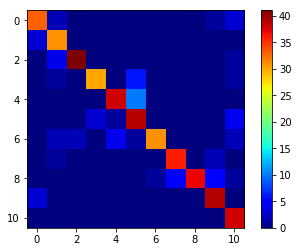

In [170]:
import numpy as np
import matplotlib.pyplot as plt

conf_arr = [[33,2,0,0,0,0,0,0,0,1,3], 
            [3,31,0,0,0,0,0,0,0,0,0], 
            [0,4,41,0,0,0,0,0,0,0,1], 
            [0,1,0,30,0,6,0,0,0,0,1], 
            [0,0,0,0,38,10,0,0,0,0,0], 
            [0,0,0,3,1,39,0,0,0,0,4], 
            [0,2,2,0,4,1,31,0,0,0,2],
            [0,1,0,0,0,0,0,36,0,2,0], 
            [0,0,0,0,0,0,1,5,37,5,1], 
            [3,0,0,0,0,0,0,0,0,39,0], 
            [0,0,0,0,0,0,0,0,0,0,38]]

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(conf_arr), cmap=plt.cm.jet, 
                interpolation='nearest')
#width, height = parameters.number_classes,parameters.number_classes

#for x in range(width):
#    for y in range(height):
#        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
#                    horizontalalignment='center',
#                    verticalalignment='center')

cb = fig.colorbar(res)
#alphabet = '0123'
#plt.xticks(range(width), alphabet[:width])
#plt.yticks(range(height), alphabet[:height])
plt.show()

In [ ]:
from graphviz import Digraph
import re
import torchvision.models as models


def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                value = '('+(', ').join(['%d'% v for v in var.size()])+')'
                dot.node(str(id(var)), str(value), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
    add_nodes(var.creator)
    return dot

In [ ]:
"""
    Test function : IoU
    return a matrix of confusion
"""
def IoU(y_train_estimated, y_train):
    
    #We keep only the higest value, which is the prediction
    pred = torch.max(y_train_estimated, dim=1)[1]

    confusion_matrix = [[0] * parameters.number_classes for i in range(parameters.number_classes)]
    
    #For each classes : [0] = TP [1] = FP [2] = FN
    IoU_each_classes = np.zeros(shape = (3,parameters.number_classes))

    pred = pred.view(-1)
    target = y_train.view(-1)

    # Double loop over the number of classes at each iteration we add the intersection
    for cls1 in range(parameters.number_classes):
        pred_inds = pred == cls1
        for cls2 in range(parameters.number_classes):
            target_inds = target == cls2
            intersection = (pred_inds*target_inds).long().sum().data.cpu()[0]
            confusion_matrix[cls1][cls2] = intersection

            # TP here for each classes
            if(cls1 == cls2):
                IoU_each_classes[0,cls1] = intersection
            # FN and FP here for each classes
            else:
                IoU_each_classes[1,cls1] = IoU_each_classes[1,cls1] + intersection
                IoU_each_classes[2,cls2] = IoU_each_classes[2,cls1] + intersection
    
    # compute the IoU value
    IoU_each_classes_total = IoU_each_classes[0,:]/np.sum(IoU_each_classes)

    return(confusion_matrix,IoU_each_classes_total, np.mean((np.float32(IoU_each_classes_total))))
    